In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow==2.15.1
!pip install keras
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install transformers
!pip install seaborn
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 92.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.7 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import keras
import sklearn
import pandas as pd
import numpy as np
import transformers
import seaborn as sns
import shap

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)
print("Transformers version:", transformers.__version__)
print("Seaborn version:", sns.__version__)
print("SHAP version:", shap.__version__)

TensorFlow version: 2.15.1
Keras version: 2.15.0
Scikit-learn version: 1.2.2
Pandas version: 2.0.3
Numpy version: 1.25.2
Transformers version: 4.38.2
Seaborn version: 0.13.1
SHAP version: 0.45.0


**Load the Pre-trained Model and its decoders**

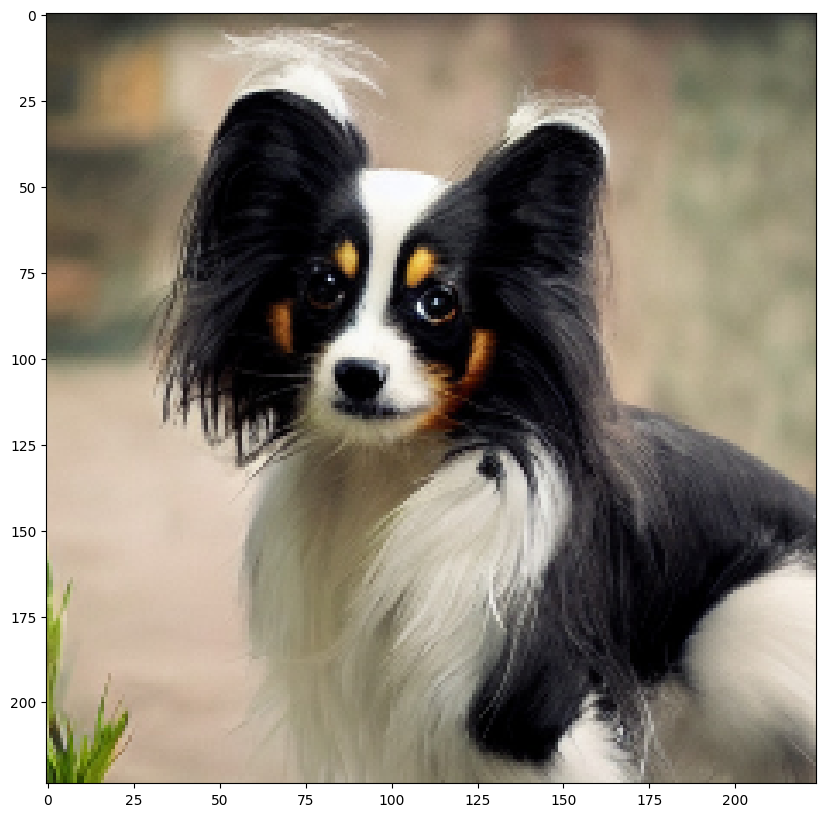

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the image
image_path = "/content/drive/MyDrive/Backups : SHAP -Image-to-text /SHAP Image-to-text/SHAP for image-to-text model/Test_Images_2/Papillion dog.jpg"

# Define the directory containing the image
custom_image = cv2.imread(image_path)

# Preprocess the image
custom_image = cv2.cvtColor(custom_image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
image = cv2.resize(custom_image, (224, 224))  # Resize to fit model input size

# Plot reshaped image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [ ]:
from tensorflow.keras.applications import DenseNet121, imagenet_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import PIL
from PIL import Image

# Load the pre-trained DenseNet121 model with ImageNet weights
model = DenseNet121(weights="imagenet")

# Define the target image size (DenseNet121 expects 224x224)
target_size = (224, 224)

# Load the image
img = load_img(image_path, target_size=target_size)

# Convert the image to a NumPy array
img_array = img_to_array(img)

# Preprocess the image (normalize pixel values between 0 and 1)
img_array = img_array / 255.0

# Expand the dimensions of the image to match the model's input format
img_array = np.expand_dims(img_array, axis=0)

# Predict the class probabilities
predictions = model.predict(img_array)

# Decode the predictions to obtain the top 3 class labels and probabilities
decoded_predictions = imagenet_utils.decode_predictions(predictions, top=3)[0]

print("Top 3 predictions:")
for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
    print(f"{i + 1}: {label} ({score:.2f})")
# Decode the predictions to obtain the class labels
decoded_predictions = imagenet_utils.decode_predictions(predictions)

35363/35363 [==============================] - 0s 0us/step
Top 3 predictions:
1: papillon (0.97)
2: Japanese_spaniel (0.02)
3: Border_collie (0.00)


**Initialize the Explainer - SHAP**

In [ ]:
# SHAP Explainer
import json
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
import shap

def f(X):
    tmp = X.copy()
    preprocess_input(tmp)
    return model(tmp)

X, y = shap.datasets.imagenet50()

# load the ImageNet class names as a vectorized mapping function from ids to names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]

# define a masker that is used to mask out partitions of the input image, this one uses a blurred background
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# By default the Partition explainer is used for all  partition explainer
explainer = shap.Explainer(f, masker, output_names=class_names)

['papillon', 'Japanese_spaniel', 'Border_collie', 'Bernese_mountain_dog', 'toy_terrier']


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:48, 48.10s/it]               


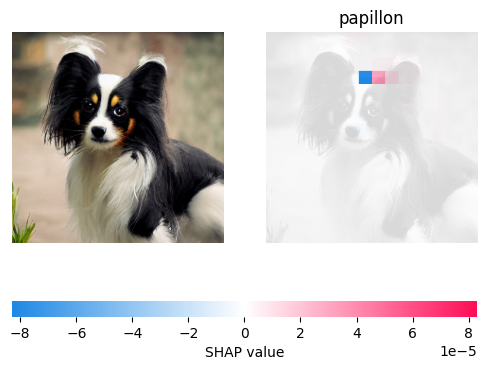

In [ ]:
import shap
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Assuming 'decoded_predictions' contains the top 3 predictions
top_predictions = decoded_predictions[0]

# Extracting the labels from the predictions
labels = [label for _, label, _ in top_predictions]

print(labels)

# Define the directory containing the image
custom_image = cv2.imread(image_path)

# Preprocess the image
custom_image = cv2.cvtColor(custom_image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
custom_image = cv2.resize(custom_image, (224, 224))  # Resize to fit model input size
custom_image = custom_image.astype(np.float32) / 255.0  # Normalize pixel values

# Get SHAP values
shap_values = explainer(
    custom_image.reshape(1, 224, 224, 3), max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:1]
)

# Plot SHAP values
shap.image_plot(shap_values[0], custom_image, labels=labels)
plt.show()

In [ ]:
# Extract the co-ordinates with maximum SHAP values
shap_values_abs = np.abs(shap_values[0].values)
top_indices = shap_values_abs.argsort(axis=None)[::-1]  # Get indices of all regions sorted by SHAP value (descending)
top_coordinates = np.unravel_index(top_indices, shap_values_abs.shape)  # Convert indices to coordinates

# Track selected scores and coordinates to ensure uniqueness
selected_scores = set()
selected_coordinates = []

print("Top SHAP Scores and their Coordinates in Original Image:")
for i in range(len(top_indices)):
    coord = tuple(coord[i] for coord in top_coordinates)  # Ensure coordinates are in tuple form
    score = shap_values_abs[coord]
    if score not in selected_scores:  # Check if score is unique
        selected_scores.add(score)
        selected_coordinates.append((score, coord))

# Print and store the unique scores and coordinates
for i, (score, coord) in enumerate(selected_coordinates[:10]):
    print(f"Top {i+1}: Score={score}, Coordinates={coord}")

# Extracting y and x coordinates from the first channel (index 0) only
coordinates = [(coord[1][1], coord[1][0]) for coord in selected_coordinates if coord[1][2] == 2]

print(f'Top 3 SHAP Value Coordinates: {coordinates[:3]}')

Top SHAP Scores and their Coordinates in Original Image:
Top 1: Score=2.7657088943991532e-05, Coordinates=(49, 108, 2, 0)
Top 2: Score=2.765708894399153e-05, Coordinates=(49, 104, 1, 0)
Top 3: Score=2.6773240359430363e-05, Coordinates=(47, 109, 0, 0)
Top 4: Score=2.6773240359430356e-05, Coordinates=(48, 108, 0, 0)
Top 5: Score=2.6773240359430353e-05, Coordinates=(44, 103, 0, 0)
Top 6: Score=1.1800807696010057e-05, Coordinates=(51, 124, 2, 0)
Top 7: Score=1.1800807696010054e-05, Coordinates=(55, 115, 2, 0)
Top 8: Score=1.1800807696010052e-05, Coordinates=(53, 117, 0, 0)
Top 9: Score=9.561845366320362e-06, Coordinates=(46, 121, 0, 0)
Top 10: Score=3.0354981359765952e-06, Coordinates=(49, 126, 1, 0)
Top 3 SHAP Value Coordinates: [(108, 49), (124, 51), (115, 55)]


**Intialize Segment Anything Model (SAM)**

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-8_rjuu90
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-8_rjuu90
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=df4a09fac9a86426f4d4d6fac89eaac96364125a2ee91d9f569aa4b85f7b60c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-y4erdf53/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    """
    Display a mask on the given axis.

    Parameters:
    - mask: numpy array, the mask to display.
    - ax: matplotlib axis object, the axis to display the mask on.
    - random_color: bool, whether to use a random color for the mask or not.
    """
    if random_color:
        # Generate a random color with transparency
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        # Use a default color for the mask
        color = np.array([30/255, 144/255, 255/255, 0.6])

    # Get the height and width of the mask
    h, w = mask.shape[-2:]

    # Reshape the mask and multiply with color for visualization
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    # Display the mask on the axis
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    """
    Display points on the given axis.

    Parameters:
    - coords: numpy array, coordinates of points.
    - labels: numpy array, corresponding labels for each point.
    - ax: matplotlib axis object, the axis to display the points on.
    - marker_size: int, size of the marker for each point.
    """
    # Separate positive and negative points based on labels
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]

    # Plot positive points in green
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

    # Plot negative points in red
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    """
    Display a bounding box on the given axis.

    Parameters:
    - box: list or array, containing coordinates of the box [x0, y0, x1, y1].
    - ax: matplotlib axis object, the axis to display the box on.
    """
    # Extract box coordinates
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]

    # Add rectangle patch to the axis
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


In [ ]:
# Load and set the SAM predictor from the local directory

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/content/drive/MyDrive/SHAP for image-to-text model (1)/SAM/sam_vit_h_4b8939.pth"
model_type = "vit_h"

#device = "cuda"
device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [ ]:
# Fix the co-ordinates and the number of inputs (prompts) to the SAM model.

converted_array = np.array(coordinates) # convert the co-ordinates to a array

input_point = converted_array[:1] # set the prompts
print(input_point)

input_label = np.array([1]) # set the number of prompts
print(input_label)

[[108  49]]
[1]


In [ ]:
# Load the image and process it for SAM.

import cv2
import matplotlib.pyplot as plt
import numpy as np

# Define the directory containing the image
custom_image = cv2.imread(image_path)

# Preprocess the image
custom_image = cv2.cvtColor(custom_image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
image = cv2.resize(custom_image, (224, 224))  # Resize to fit model input size

In [ ]:
# Set the predictor to the input image

predictor.set_image(image)

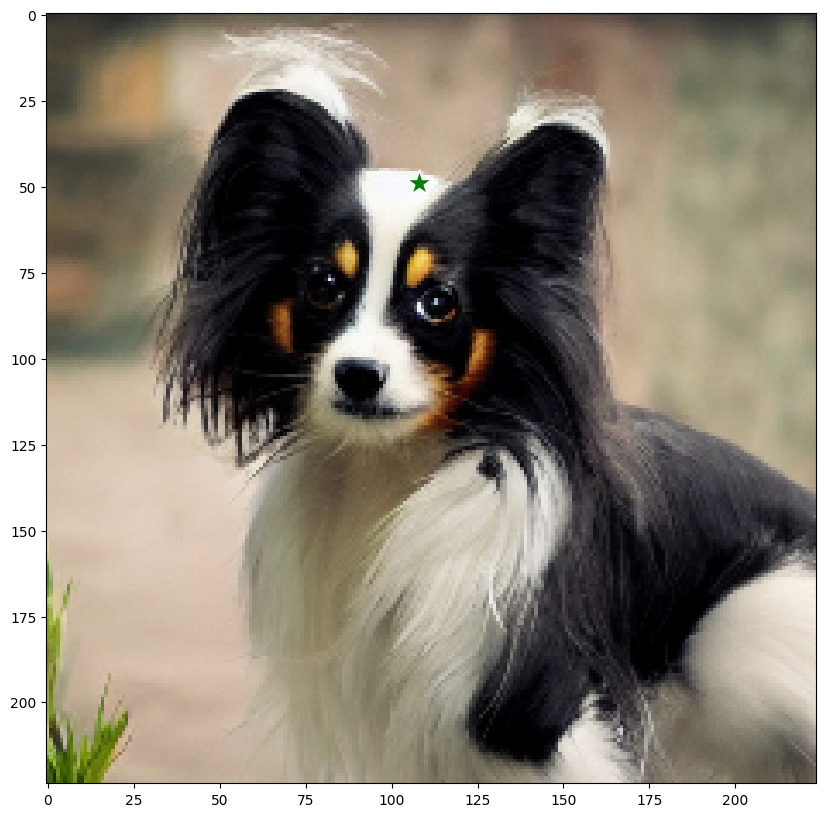

In [ ]:
# Visualize the co-ordinates with maximum SHAP values.

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [ ]:
# Predict the segments using SAM with prompt (co-ordinates with maximum SHAP value)

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

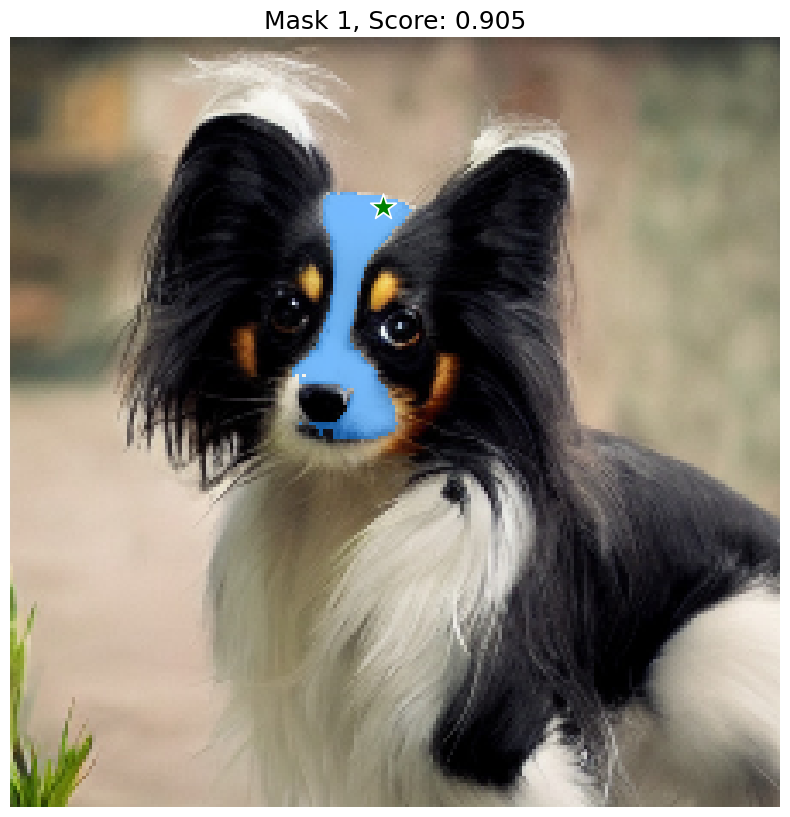

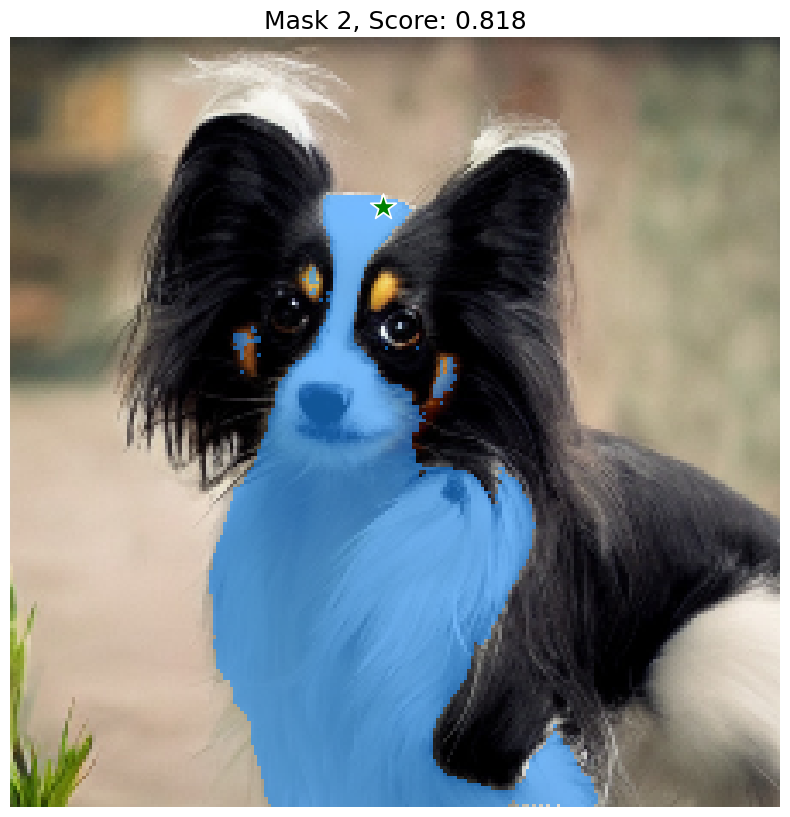

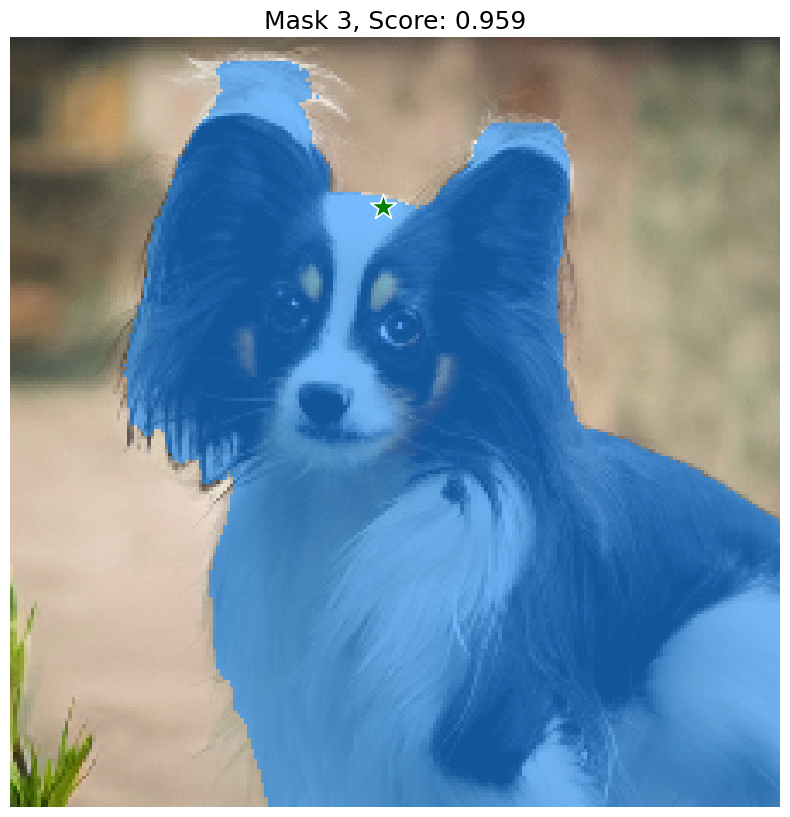

In [ ]:
# Visualize the results

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

In [ ]:
import cv2

# Find index of mask with highest score
index_of_highest_score = np.argmax(scores)


# Save the image in the masked region and explain further.

import cv2

# Find index of mask with highest score
mask_with_highest_score = masks[-1]

# Apply the mask to the original image to extract content inside the mask
image_with_mask = image.copy()  # Assuming 'image' is the original image
image_with_mask[mask_with_highest_score == 0] = [0, 0, 0]  # Set pixels outside mask to black

# Save the image with only content inside the mask overlaid
content_inside_mask_on_original_image_path = "content_inside_mask_on_original_image.jpg"
cv2.imwrite(content_inside_mask_on_original_image_path, cv2.cvtColor(image_with_mask, cv2.COLOR_RGB2BGR))

# Now you have the original image with only content inside the mask overlaid saved as an image
print("Original image with content inside the mask overlaid saved at:", content_inside_mask_on_original_image_path)

Original image with content inside the mask overlaid saved at: content_inside_mask_on_original_image.jpg


**Initialize the VLM ; LLaVA**

In [ ]:
!pip install git+https://github.com/DLCV-BUAA/TinyLLaVABench.git

  Cloning https://github.com/DLCV-BUAA/TinyLLaVABench.git to /tmp/pip-req-build-7hkaeq7k
  Running command git clone --filter=blob:none --quiet https://github.com/DLCV-BUAA/TinyLLaVABench.git /tmp/pip-req-build-7hkaeq7k
  Resolved https://github.com/DLCV-BUAA/TinyLLaVABench.git to commit 2d2105fc7d44781464e7f503986bbfac270a8e22
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 102.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 100.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 35.0 MB/s eta 0:00:00
     ━━━━

In [ ]:
device = "cuda"

In [ ]:
from tinyllava.model.builder import load_pretrained_model
from tinyllava.mm_utils import get_model_name_from_path
from tinyllava.eval.run_tiny_llava import eval_model
model_path = "bczhou/TinyLLaVA-3.1B"
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None,
    model_name=get_model_name_from_path(model_path)
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors.index.json:   0%|          | 0.00/88.7k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at bczhou/TinyLLaVA-3.1B were not used when initializing TinyLlavaPhiForCausalLM: ['model.vision_tower.vision_tower.vision_model.embeddings.patch_embedding.bias', 'model.vision_tower.vision_tower.vision_model.embeddings.patch_embedding.weight', 'model.vision_tower.vision_tower.vision_model.embeddings.position_embedding.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.ml

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/796M [00:00<?, ?B/s]

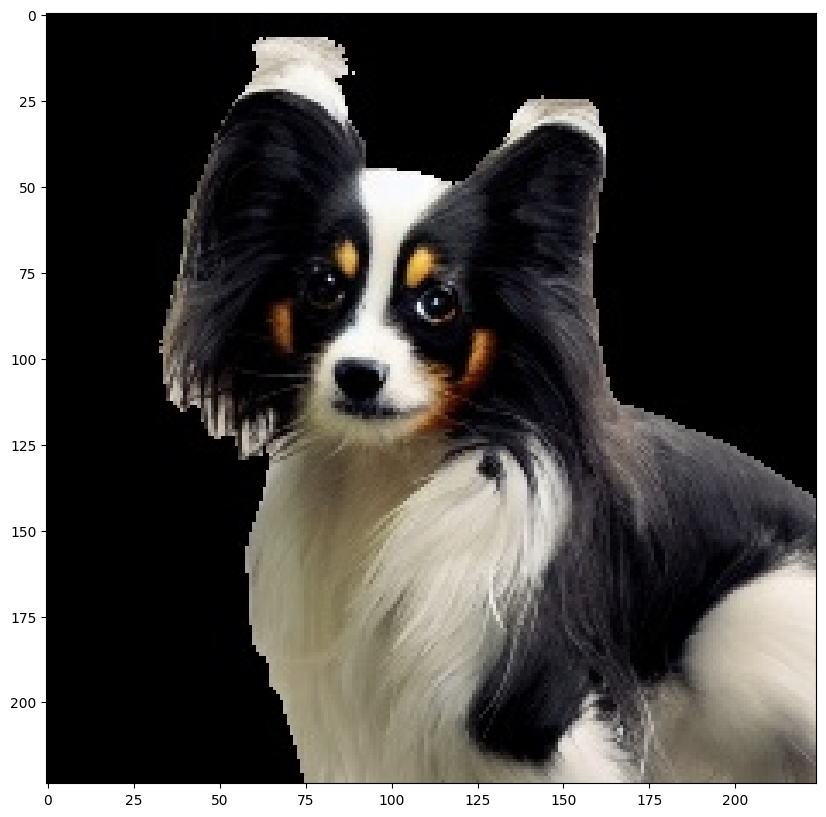

In [ ]:
import cv2
import matplotlib.pyplot as plt

image_file = "./content_inside_mask_on_original_image.jpg"
custom_image = cv2.imread(image_file)

# Preprocess the image
custom_image = cv2.cvtColor(custom_image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
image = cv2.resize(custom_image, (224, 224))  # Resize to fit model input size

# Plot reshaped image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [ ]:
{top_3_labels[0]} # replace with the label 'Actual Predicted Label' ;

In [ ]:
from tinyllava.model.builder import load_pretrained_model
from tinyllava.mm_utils import get_model_name_from_path
from tinyllava.eval.run_tiny_llava import eval_model
model_path = "bczhou/TinyLLaVA-3.1B"
prompt = f"Explain the object in the image: 'papillon'?"
image_file = "./content_inside_mask_on_original_image.jpg"

args = type('Args', (), {
    "model_path": model_path,
    "model_base": None,
    "model_name": get_model_name_from_path(model_path),
    "query": prompt,
    "conv_mode": "phi",
    "image_file": image_file,
    "sep": ",",
    "temperature": 0,
    "top_p": 1,
    "num_beams": 1,
    "max_new_tokens": 1024
})()
eval_model(args)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at bczhou/TinyLLaVA-3.1B were not used when initializing TinyLlavaPhiForCausalLM: ['model.vision_tower.vision_tower.vision_model.embeddings.patch_embedding.bias', 'model.vision_tower.vision_tower.vision_model.embeddings.patch_embedding.weight', 'model.vision_tower.vision_tower.vision_model.embeddings.position_embedding.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.ml

The image features a Papillon dog, which is a small, long-haired breed known for its distinctive appearance. The dog has a white and black coat, with a large, fluffy tail and ears. The dog is looking directly at the camera, giving the impression that it is posing for the photo. The background is black, which contrasts with the dog's white and black fur, making the dog stand out in the image. The dog's position and the way it is looking at the camera suggest that it is comfortable and at ease in the situation.
